In [4]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D0926 19:20:11.117029514      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0926 19:20:11.117054710      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0926 19:20:11.117058338      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0926 19:20:11.117061367      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0926 19:20:11.117064024      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0926 19:20:11.117067027      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0926 19:20:11.117069667      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0926 19:20:11.

/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv


In [5]:
df = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv')
df

id  breath_id   R   C  time_step       u_in  u_out   pressure
0              1          1  20  50   0.000000   0.083334      0   5.837492
1              2          1  20  50   0.033652  18.383041      0   5.907794
2              3          1  20  50   0.067514  22.509278      0   7.876254
3              4          1  20  50   0.101542  22.808822      0  11.742872
4              5          1  20  50   0.135756  25.355850      0  12.234987
...          ...        ...  ..  ..        ...        ...    ...        ...
6035995  6035996     125749  50  10   2.504603   1.489714      1   3.869032
6035996  6035997     125749  50  10   2.537961   1.488497      1   3.869032
6035997  6035998     125749  50  10   2.571408   1.558978      1   3.798729
6035998  6035999     125749  50  10   2.604744   1.272663      1   4.079938
6035999  6036000     125749  50  10   2.638017   1.482739      1   3.869032

[6036000 rows x 8 columns]

In [6]:
df['volume'] = df['pressure'] * df['C']
df['flow_rate'] = df['volume'] / df['time_step']
df['D'] = df['time_step'] / df['u_in']
df['pressure_diff'] = df['flow_rate'] * df['R']
df

id  breath_id   R   C  time_step       u_in  u_out   pressure  \
0              1          1  20  50   0.000000   0.083334      0   5.837492   
1              2          1  20  50   0.033652  18.383041      0   5.907794   
2              3          1  20  50   0.067514  22.509278      0   7.876254   
3              4          1  20  50   0.101542  22.808822      0  11.742872   
4              5          1  20  50   0.135756  25.355850      0  12.234987   
...          ...        ...  ..  ..        ...        ...    ...        ...   
6035995  6035996     125749  50  10   2.504603   1.489714      1   3.869032   
6035996  6035997     125749  50  10   2.537961   1.488497      1   3.869032   
6035997  6035998     125749  50  10   2.571408   1.558978      1   3.798729   
6035998  6035999     125749  50  10   2.604744   1.272663      1   4.079938   
6035999  6036000     125749  50  10   2.638017   1.482739      1   3.869032   

             volume    flow_rate         D  pressure_diff  
0        291.874585          inf  0.000000            inf  
1        295.389693  8777.695532  0.001831   1.755539e+05  
2        393.812696  5833.016099  0.002999   1.166603e+05  
3        587.143596  5782.259958  0.004452   1.156452e+05  
4        611.749347  4506.256996  0.005354   9.012514e+04  
...             ...          ...       ...            ...  
6035995   38.690316    15.447683  1.681265   7.723842e+02  
6035996   38.690316    15.244647  1.705049   7.622324e+02  
6035997   37.987295    14.772958  1.649419   7.386479e+02  
6035998   40.799381    15.663487  2.046688   7.831744e+02  
6035999   38.690316    14.666437  1.779151   7.333219e+02  

[6036000 rows x 12 columns]

In [7]:
rows_with_inf = df[df.apply(lambda row: np.any(np.isinf(row)), axis=1)]
df_1 = df.drop(rows_with_inf.index)

In [8]:
df_1.isna().value_counts()

id     breath_id  R      C      time_step  u_in   u_out  pressure  volume  flow_rate  D      pressure_diff
False  False      False  False  False      False  False  False     False   False      False  False            4551325
Name: count, dtype: int64

In [9]:
sampled_df = df_1.groupby('pressure' ,group_keys=False).apply(lambda x:x.sample(min(len(x) ,1)))
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 950 entries, 5349582 to 420890
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             950 non-null    int64  
 1   breath_id      950 non-null    int64  
 2   R              950 non-null    int64  
 3   C              950 non-null    int64  
 4   time_step      950 non-null    float64
 5   u_in           950 non-null    float64
 6   u_out          950 non-null    int64  
 7   pressure       950 non-null    float64
 8   volume         950 non-null    float64
 9   flow_rate      950 non-null    float64
 10  D              950 non-null    float64
 11  pressure_diff  950 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 96.5 KB


In [10]:
unique_C = sampled_df['C'].unique()
unique_R = sampled_df['R'].unique()

print(f"The unique value of C :{unique_C}")
print(f"The unique value of R :{unique_R}")

The unique value of C :[10 20 50]
The unique value of R :[50  5 20]


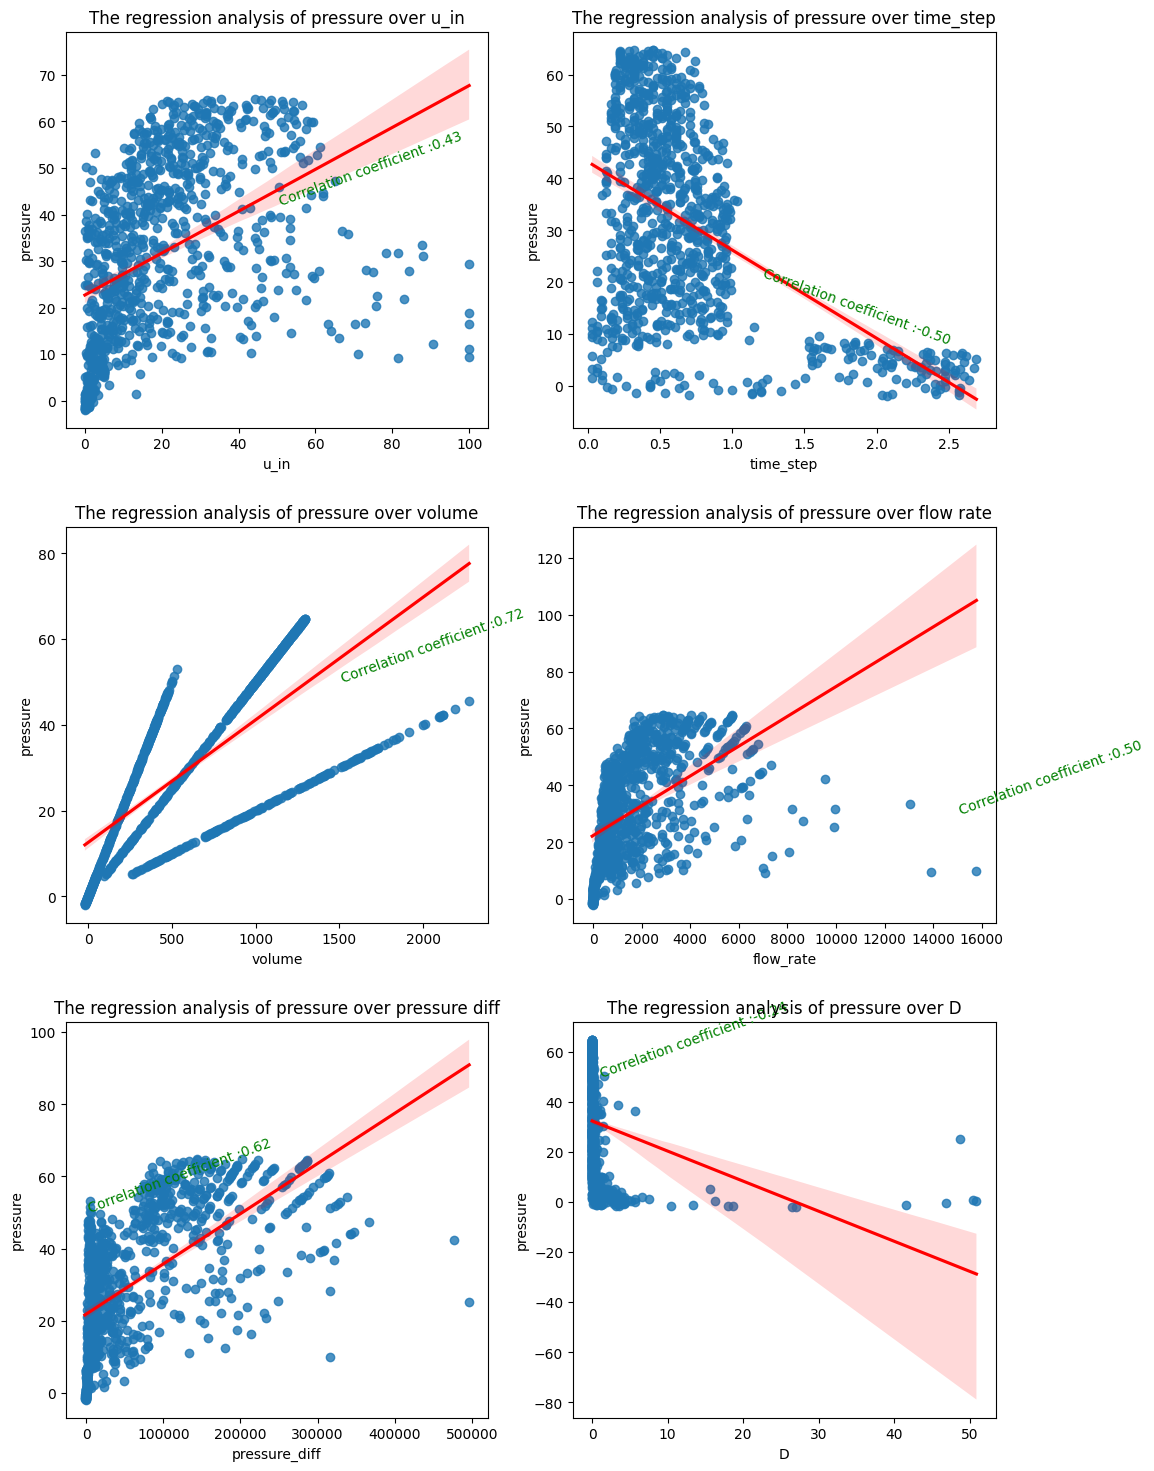

In [11]:
fig, ((ax1, ax2) ,(ax3 ,ax4) ,(ax5 ,ax6)) = plt.subplots(3, 2, figsize=(12, 18))

sns.regplot(x='u_in', y='pressure', data=sampled_df ,ax=ax1 ,line_kws = {'color' : 'red'})
sns.regplot(x='time_step', y='pressure', data=sampled_df ,ax=ax2 ,line_kws = {'color' : 'red'})
sns.regplot(x='volume', y='pressure', data=sampled_df ,ax=ax3 ,line_kws = {'color' : 'red'})
sns.regplot(x='flow_rate', y='pressure', data=sampled_df ,ax=ax4 ,line_kws = {'color' : 'red'})
sns.regplot(x='pressure_diff', y='pressure', data=sampled_df ,ax=ax5 ,line_kws = {'color' : 'red'})
sns.regplot(x='D', y='pressure', data=sampled_df ,ax=ax6 ,line_kws = {'color' : 'red'})

ax1.set_title('The regression analysis of pressure over u_in')
ax2.set_title('The regression analysis of pressure over time_step')
ax3.set_title('The regression analysis of pressure over volume')
ax4.set_title('The regression analysis of pressure over flow rate')
ax5.set_title('The regression analysis of pressure over pressure diff')
ax6.set_title('The regression analysis of pressure over D')


corr1 = sampled_df['pressure'].corr(sampled_df['u_in'])
corr2 = sampled_df['pressure'].corr(sampled_df['time_step'])
corr3 = sampled_df['pressure'].corr(sampled_df['volume'])
corr4 = sampled_df['pressure'].corr(sampled_df['flow_rate'])
corr5 = sampled_df['pressure'].corr(sampled_df['pressure_diff'])
corr6 = sampled_df['pressure'].corr(sampled_df['D'])

ax1.annotate(f'Correlation coefficient :{corr1:.2f}' ,xy=(50 ,42) ,rotation=20 ,color='green')
ax2.annotate(f'Correlation coefficient :{corr2:.2f}' ,xy=(1.2 ,8) ,rotation=-20 ,color='green')
ax3.annotate(f'Correlation coefficient :{corr3:.2f}' ,xy=(1500 ,50) ,rotation=20 ,color='green')
ax4.annotate(f'Correlation coefficient :{corr4:.2f}' ,xy=(15000 ,30) ,rotation=20 ,color='green')
ax5.annotate(f'Correlation coefficient :{corr5:.2f}' ,xy=(0.8 ,50) ,rotation=20 ,color='green')
ax6.annotate(f'Correlation coefficient :{corr6:.2f}' ,xy=(0.8 ,50) ,rotation=20 ,color='green')


plt.subplots_adjust(hspace=0.25)

plt.show()

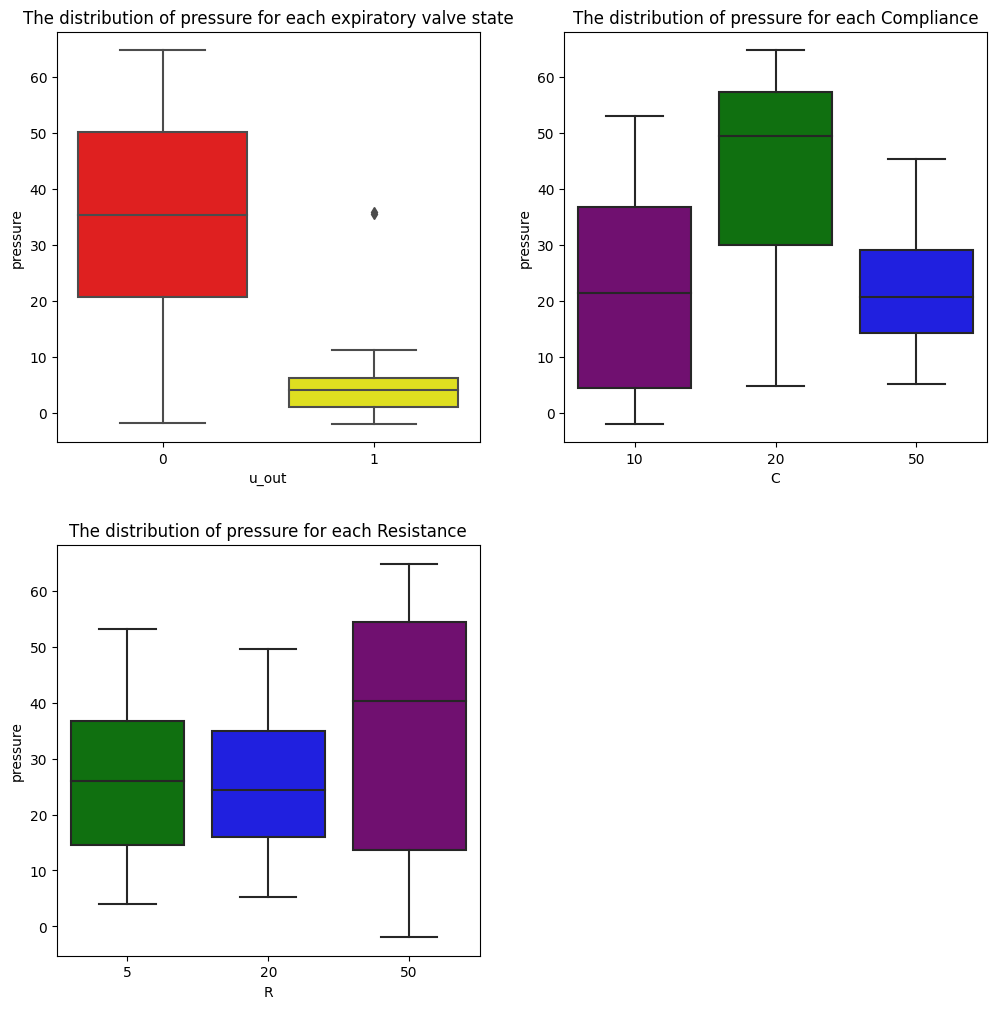

In [12]:
fig, ((ax1, ax2) ,(ax3 ,ax4)) = plt.subplots(2, 2, figsize=(12, 12))

sns.boxplot(x='u_out', y='pressure', data=sampled_df, ax=ax1, color='blue' ,palette={0:'red' ,1:'yellow'})
sns.boxplot(x='C', y='pressure', data=sampled_df, ax=ax2, color='blue' ,palette={10:'purple' ,20:'green' ,50:'blue'})
sns.boxplot(x='R', y='pressure', data=sampled_df, ax=ax3, color='blue' ,palette={50:'purple' ,5:'green' ,20:'blue'})

ax1.set_title('The distribution of pressure for each expiratory valve state')
ax2.set_title('The distribution of pressure for each Compliance')
ax3.set_title('The distribution of pressure for each Resistance')

ax4.axis('off')

plt.subplots_adjust(hspace=0.25)
plt.show()

In [13]:
X = df_1[['R', 'C', 'time_step', 'u_in', 'u_out' ,'volume' ,'flow_rate' ,'pressure_diff' ,'D']]
Scaler = StandardScaler()
Scaler.fit(X)
X_scaled = Scaler.transform(X)
y = df_1['pressure']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.01, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"X_train shape :{X_train.shape}")
print(f"y_train shape :{y_train.shape}")
print(f"X_val shape :{X_val.shape}")
print(f"y_val shape :{y_val.shape}")
print(f"X_test shape :{X_test.shape}")
print(f"y_test shape :{y_test.shape}")
print(f"X_temp shape :{X_temp.shape}")
print(f"y_temp shape :{y_temp.shape}")

X_train shape :(4505811, 9)
y_train shape :(4505811,)
X_val shape :(22757, 9)
y_val shape :(22757,)
X_test shape :(22757, 9)
y_test shape :(22757,)
X_temp shape :(45514, 9)
y_temp shape :(45514,)


In [14]:
is_inf_value_X_train = np.isinf(X_train).sum()
is_inf_value_y_train = np.isinf(y_train).sum()
is_inf_value_X_val = np.isinf(X_val).sum()
is_inf_value_y_val = np.isinf(y_val).sum()
print(f"is_inf_value_X_train :{is_inf_value_X_train}")
print(f"is_inf_value_y_train :{is_inf_value_y_train}")
print(f"is_inf_value_X_val :{is_inf_value_X_val}")
print(f"is_inf_value_y_val :{is_inf_value_y_val}")

is_inf_value_X_train :R                0
C                0
time_step        0
u_in             0
u_out            0
volume           0
flow_rate        0
pressure_diff    0
D                0
dtype: int64
is_inf_value_y_train :0
is_inf_value_X_val :R                0
C                0
time_step        0
u_in             0
u_out            0
volume           0
flow_rate        0
pressure_diff    0
D                0
dtype: int64
is_inf_value_y_val :0


# 1. **Linear Regression model :training & evaluation**

In [15]:
Lr = LinearRegression()
Lr.fit(X_train ,y_train)

LinearRegression()

In [16]:
y_train_pred = Lr.predict(X_train)
y_val_pred = Lr.predict(X_val)
y_test_pred = Lr.predict(X_test)

In [17]:
train_mse = mean_squared_error(y_train ,y_train_pred)
val_mse = mean_squared_error(y_val ,y_val_pred)
test_mse = mean_squared_error(y_test ,y_test_pred)

print(f"train mse error :{train_mse}")
print(f"val mse error :{val_mse}")
print(f"test mse error :{test_mse}")

train mse error :14.603954397115098
val mse error :14.470978745329377
test mse error :14.32251475275173


In [18]:
train_r2 = r2_score(y_train ,y_train_pred)
val_r2 = r2_score(y_val ,y_val_pred)
test_r2 = r2_score(y_test ,y_test_pred)

print(f"train r2 score :{train_r2}")
print(f"val r2 score :{val_r2}")
print(f"test r2 score :{test_r2}")

train r2 score :0.7588965295989288
val r2 score :0.7606639179287911
test r2 score :0.7586470009664208


# 2. **Artificial Neural Network :Training & evaluation**

In [26]:
Model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(units=128 ,activation='relu'),
    tf.keras.layers.Dense(units=64 ,activation='relu'),
    tf.keras.layers.Dense(units=32 ,activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [27]:
Model.compile(optimizer='adam' ,loss=tf.losses.Huber(delta=1.0) ,metrics='mean_squared_error')

In [28]:
History = Model.fit(X_train, y_train, epochs=7, validation_data=(X_val, y_val))

Epoch 1/7
140807/140807 [==============================] - 226s 2ms/step - loss: 1.4407 - mean_squared_error: 448.9748 - val_loss: 0.6125 - val_mean_squared_error: 3.4810
Epoch 2/7
140807/140807 [==============================] - 224s 2ms/step - loss: 0.2054 - mean_squared_error: 1.2788 - val_loss: 0.1247 - val_mean_squared_error: 0.3856
Epoch 3/7
140807/140807 [==============================] - 223s 2ms/step - loss: 0.1413 - mean_squared_error: 0.9378 - val_loss: 0.1428 - val_mean_squared_error: 0.3136
Epoch 4/7
140807/140807 [==============================] - 222s 2ms/step - loss: 0.1676 - mean_squared_error: 1.0286 - val_loss: 0.0249 - val_mean_squared_error: 0.0519
Epoch 5/7
140807/140807 [==============================] - 222s 2ms/step - loss: 0.0952 - mean_squared_error: 0.8500 - val_loss: 0.1043 - val_mean_squared_error: 0.3445
Epoch 6/7
140807/140807 [==============================] - 224s 2ms/step - loss: 0.0980 - mean_squared_error: 0.5137 - val_loss: 0.0288 - val_mean_square

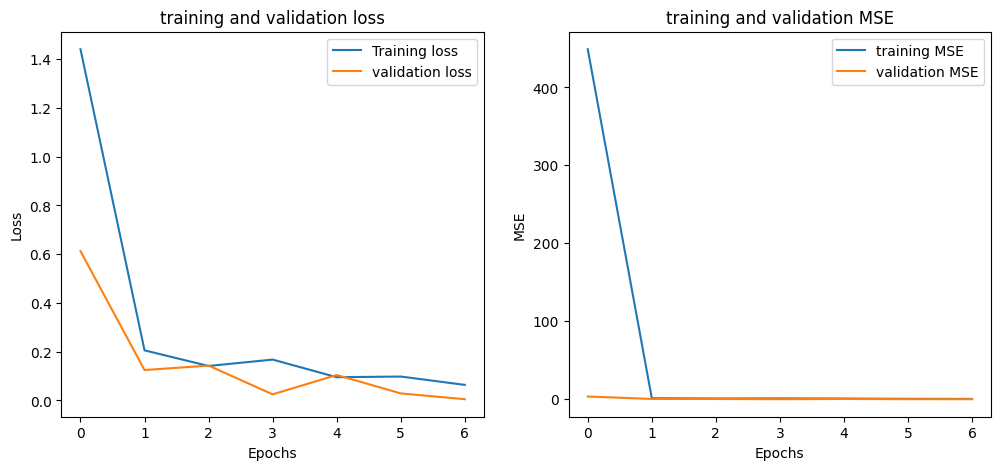

In [29]:
training_loss = History.history['loss']
validation_loss = History.history['val_loss']

training_MSE = History.history['mean_squared_error']
validation_MSE = History.history['val_mean_squared_error']

fig ,(ax1 ,ax2) = plt.subplots(1 ,2 ,figsize=(12 ,5))

ax1.plot(training_loss ,label='Training loss')
ax1.plot(validation_loss ,label='validation loss')
ax1.set_title('training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(training_MSE ,label='training MSE')
ax2.plot(validation_MSE ,label='validation MSE')
ax2.set_title('training and validation MSE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')
ax2.legend()


plt.show()

In [30]:
y_train_pred = Model.predict(X_train)
y_val_pred = Model.predict(X_val)
y_test_pred = Model.predict(X_test)


train_mse = mean_squared_error(y_train ,y_train_pred)
val_mse = mean_squared_error(y_val ,y_val_pred)
test_mse = mean_squared_error(y_test ,y_test_pred)

print(f"y_val_pred :{y_val_pred}")
print(f"y_test_pred :{y_test_pred}")

print(f"train mse error :{train_mse}")
print(f"val mse error :{val_mse}")
print(f"test mse error :{test_mse}")

712/712 [==============================] - 1s 1ms/step
y_val_pred :[[15.244488 ]
 [ 6.3836913]
 [11.477637 ]
 ...
 [ 8.722801 ]
 [31.909695 ]
 [ 5.750358 ]]
y_test_pred :[[15.421642]
 [ 6.503954]
 [16.99568 ]
 ...
 [25.753975]
 [ 5.559965]
 [14.840261]]
train mse error :0.017261684258277597
val mse error :0.011175856427460162
test mse error :0.01322987845179338


In [31]:
train_r2 = r2_score(y_train ,y_train_pred)
val_r2 = r2_score(y_val ,y_val_pred)
test_r2 = r2_score(y_test ,y_test_pred)

print(f"train r2 score :{train_r2}")
print(f"val r2 score :{val_r2}")
print(f"test r2 score :{test_r2}")

train r2 score :0.9997150188321281
val r2 score :0.999815162074507
test r2 score :0.9997770593435362
